## Anti-WindUp

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term
        derivative = (error - self.prev_error) / dt
        D = self.Kd * derivative
        
        # Save error for next derivative calculation
        self.prev_error = error
        
        # Compute output
        output = P + I + D
        
        return output
    
class PIDControllerWithAntiWindup(PIDController):
    def __init__(self, Kp, Ki, Kd, output_limits):
        super().__init__(Kp, Ki, Kd)
        self.output_min, self.output_max = output_limits
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term with anti-windup
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term
        derivative = (error - self.prev_error) / dt
        D = self.Kd * derivative
        
        # Save error for next derivative calculation
        self.prev_error = error
        
        # Compute raw output
        output = P + I + D
        
        if self.output_min is not None and self.output_max is not None:
            # Apply output limits
            output = np.clip(output, self.output_min, self.output_max)
            
            # Anti-windup: only integrate if not saturated
            if output != P + I + D:
                self.integral -= error * dt  # undo the integration
        
        return output


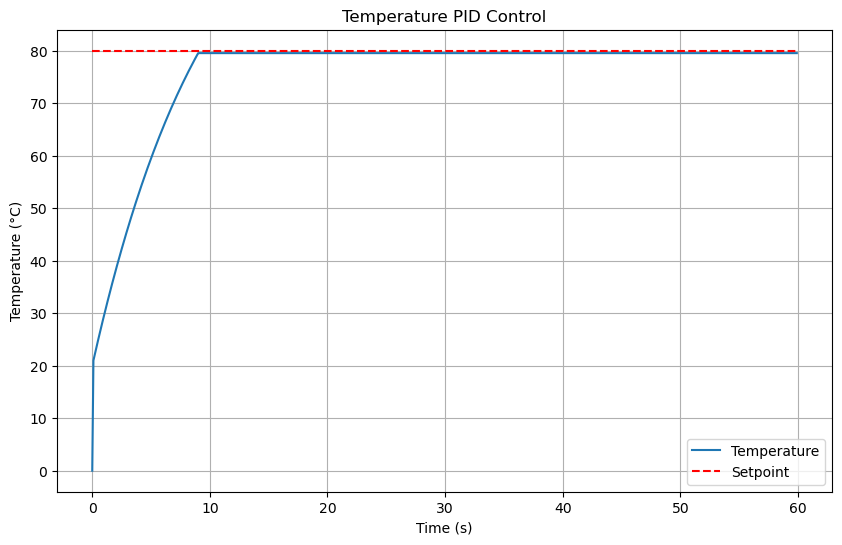

In [41]:
    
class TemperatureSystem:
    def __init__(self, ambient_temp, time_constant, heat_capacity):
        self.temp = ambient_temp
        self.ambient = ambient_temp
        self.time_constant = time_constant
        self.heat_capacity = heat_capacity
        
    def update(self, heat_input, dt):
        # Simple thermal model
        self.temp += ((heat_input / self.heat_capacity) - 
                     (self.temp - self.ambient) / self.time_constant) * dt
        return self.temp

# Simulation parameters
dt = 0.1
total_time = 60  # seconds
steps = int(total_time / dt)

# Create system and controller
system = TemperatureSystem(ambient_temp=20, time_constant=10, heat_capacity=100)
pid = PIDControllerWithAntiWindup(Kp=1300, Ki=0, Kd=0, output_limits=(0, 1000))

# Run simulation
setpoint = 80  # target temperature °C
time = np.arange(0, total_time, dt)
temperature = np.zeros_like(time)

for i in range(1, len(time)):
    control = pid.compute(setpoint, system.temp, dt)
    temperature[i] = system.update(control, dt)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, temperature, label='Temperature')
plt.plot(time, [setpoint]*len(time), 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature PID Control')
plt.legend()
plt.grid(True)
plt.show()